### Load

In [ ]:
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors, KDTree
from sklearn.cluster import dbscan
from sklearn.neighbors import kneighbors_graph

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score
from scipy.sparse.csgraph import connected_components

import networkx as nx
import csv
from collections import Counter
from scipy.stats import gaussian_kde

# For dc-distance
from scipy.linalg import expm
import itertools
import numba

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Functions

In [ ]:
def read_dcdist_results(input_file='dcdist_results.csv'):
    minPts = []
    eps_values = []
    num_connected_components = []
    num_loops = []
    nmi_values = []
    ami_values = []
    ari_values = []
    cnt_loops_norm_by_edges = []
    cnt_loops_norm_by_edges_comp = []
    graph_labels = []

    with open(input_file, mode='r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip the header

        for row in reader:
            # Extracting the values from each row, and assuming data types as required
            minPts.append(float(row[0]))  # Assuming `minPts` is numeric
            eps_values.append(float(row[1]))  # Assuming `eps` is numeric
            num_connected_components.append(int(row[2]))  # Integer for `num_connected_components`
            num_loops.append(float(row[3]))  # Integer for `num_loops`
            nmi_values.append(float(row[4]))  # Assuming `nmi` is a floating-point number
            ami_values.append(float(row[5]))  # Assuming `ami` is a floating-point number
            ari_values.append(float(row[6]))  # Assuming `ari` is a floating-point number
            cnt_loops_norm_by_edges.append(float(row[7]))  # Assuming this is a floating-point number
            cnt_loops_norm_by_edges_comp.append(float(row[8]))  # Assuming this is a floating-point number

            # Assuming graph_labels is a list represented as a string in the CSV
            graph_labels.append(eval(row[9]))  # Convert string representation back to list
            #print(minPts, eps_values)

    return minPts, eps_values, num_connected_components, num_loops, nmi_values, ami_values, ari_values, cnt_loops_norm_by_edges, cnt_loops_norm_by_edges_comp, graph_labels


In [ ]:
def frequency_plot(arr, lim_start=-1, lim_end=30, save=False, code=''):
    # No need to flatten if arr is a list of integers
    frequency_count = Counter(arr)

    x_values = list(frequency_count.keys())
    y_frequencies = list(frequency_count.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x_values, y_frequencies, color='skyblue', alpha=1)

    #kde = gaussian_kde(arr)  # Directly use arr if it is a flat list
    #x_grid = np.linspace(np.min(arr), np.max(arr), 1000)
    #kde_values = kde(x_grid)

    # Plot the KDE curve
    # ax.plot(x_grid, kde_values * len(arr), color='red', lw=1 )  # Uncomment if needed

    # Smooth approximation using Gaussian KDE
    #kde = gaussian_kde(arr)
    #x_smooth = np.linspace(lim_start, lim_end, 1000)  # Generate a smooth range of x values
    #y_smooth = kde(x_smooth) * len(arr)  # Scale KDE to match the histogram frequencies
    #ax.plot(x_smooth, y_smooth, color='red', lw=1.5, label='KDE Approximation')

    bandwidth_adjust=0.5

    kde = gaussian_kde(arr)
    kde.set_bandwidth(bw_method=kde.factor * bandwidth_adjust)  # Adjust bandwidth sensitivity
    x_smooth = np.linspace(lim_start, lim_end, 500)  # Generate a smooth range of x values
    y_smooth = kde(x_smooth) * len(arr)  # Scale KDE to match the histogram frequencies
    ax.plot(x_smooth, y_smooth, color='green', lw=1.5)


    # mean and median
    mean_value = np.mean(arr)
    print(mean_value)
    median_value = np.median(arr)
    ax.axvline(mean_value, color='coral', linestyle='--', lw=0.8, label=f'Mean: {mean_value:.2f}')
    ax.axvline(median_value, color='purple', linestyle='--', lw=0.8, label=f'Median: {median_value:.2f}')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    ax.set_xlabel('Number of Connected Components', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.set_xlim(lim_start, lim_end)
    ax.set_title('Frequency of Connected Component Counts', fontsize=18)
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    if save:
        fig.savefig("Frequency_of_connected_component"+code+".png")

    return frequency_count.most_common()

In [ ]:
def compute_nmi_per_component(components_list, num_connected_components, graph_labels):
  results={}
  for c in components_list:
    array = graph_labels[num_connected_components == c]

    nmi_values = []
    ami_values = []
    ari_values = []

    if len(array) > 1 and c != 0 and c != 1:
      for i in range(len(array)):
        for j in range(i+1, len(array)):
          nmi = normalized_mutual_info_score(array[i], array[j])
          nmi_values.append(nmi)
          #print(i,j,nmi)

          ami = adjusted_mutual_info_score(array[i], array[j])
          ami_values.append(ami)

          ari = adjusted_rand_score(array[i], array[j])
          ari_values.append(ari)

      results[c] = {
                'NMI': np.mean(nmi_values),
                'AMI': np.mean(ami_values),
                'ARI': np.mean(ari_values)
            }
    print(f"Num components: {c}, NMI: {np.mean(nmi_values):.3f}, AMI: {np.mean(ami_values):.3f}, ARI: {np.mean(ari_values):.3f}")

  return results

In [ ]:
def compute_nmi_per_component(components_list, num_connected_components, graph_labels, code='metrics_output'):
    results = {}

    for c in components_list:
        array = graph_labels[num_connected_components == c]

        nmi_values = []
        ami_values = []
        ari_values = []

        if len(array) > 1 and c != 0 and c != 1:
            for i in range(len(array)):
                for j in range(i + 1, len(array)):
                    nmi = normalized_mutual_info_score(array[i], array[j])
                    nmi_values.append(nmi)

                    ami = adjusted_mutual_info_score(array[i], array[j])
                    ami_values.append(ami)

                    ari = adjusted_rand_score(array[i], array[j])
                    ari_values.append(ari)

            nmi_mean = np.mean(nmi_values)
            ami_mean = np.mean(ami_values)
            ari_mean = np.mean(ari_values)

            results[c] = {
                'NMI': np.mean(nmi_values),
                'AMI': np.mean(ami_values),
                'ARI': np.mean(ari_values)
            }

            print(f"Component: {c}, NMI: {nmi_mean:.3f}, AMI: {ami_mean:.3f}, ARI: {ari_mean:.3f}")

    # Save results to CSV
    df = pd.DataFrame(results)
    output_csv="/content/drive/MyDrive/Colab Notebooks/NMI_"+code+".csv"
    df.to_csv(output_csv, index=False)

    return results


In [ ]:
def sum_nmi_per_component(components_list, num_connected_components, graph_labels):
  results={}
  for c in components_list:
    array = graph_labels[num_connected_components == c]

    nmi_values = []
    ami_values = []
    ari_values = []

    if len(array) > 1 and c != 0 and c != 1:
      for i in range(len(array)):
        for j in range(i+1, len(array)):
          nmi = normalized_mutual_info_score(array[i], array[j])
          nmi_values.append(nmi)
          #print(i,j,nmi)

          ami = adjusted_mutual_info_score(array[i], array[j])
          ami_values.append(ami)

          ari = adjusted_rand_score(array[i], array[j])
          ari_values.append(ari)

      results[c] = {
                'NMI': np.sum(nmi_values),
                'AMI': np.sum(ami_values),
                'ARI': np.sum(ari_values)
            }
    print(f"Num components: {c}, NMI: {np.sum(nmi_values):.3f}, AMI: {np.sum(ami_values):.3f}, ARI: {np.sum(ari_values):.3f}")

  return results

In [ ]:
def plot_metrics(results, truth, code=''):
    components = sorted(results.keys())

    nmi_values = [results[c]['NMI'] for c in components]
    ami_values = [results[c]['AMI'] for c in components]
    ari_values = [results[c]['ARI'] for c in components]

    fig=plt.figure(figsize=(10, 6))
    plt.plot(components, nmi_values, label='NMI', marker='o')
    plt.plot(components, ami_values, label='AMI', marker='s')
    plt.plot(components, ari_values, label='ARI', marker='^')

    # Highlight region around component = 10
    plt.axvspan(truth-1.5, truth+1.5, color='red', alpha=0.2)

    plt.title('NMI, AMI, ARI per Component')
    plt.xlabel('Number of Connected Components')
    plt.ylabel('Score')
    #plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("/content/drive/MyDrive/Colab Notebooks/NMI_"+code+".png")


In [ ]:
def get_top_components_by_metric(results, metric, top_n=3):
    # Сортируем компоненты по значению метрики и выбираем топ-N
    sorted_components = sorted(results.items(), key=lambda x: x[1][metric], reverse=True)

    # Выводим топ-N результатов
    top_components = sorted_components[:top_n]

    print(f"Top {top_n} components by {metric}:")
    for component, metrics in top_components:
        print(f"Component: {component}, {metric}: {metrics[metric]:.3f}")

    return top_components

In [ ]:
def create_heatmap(input_file, metric, highlight=False, title='', minPts_limit=None, eps_limit=None):
    # Read data
    minPts, eps_values, num_connected_components, num_loops, nmi_values, ami_values, ari_values, cnt_loops_norm_by_edges, cnt_loops_norm_by_edges_comp, graph_labels = read_dcdist_results(input_file)

    # Choose the metric to visualize
    metrics = {
        "num_connected_components": num_connected_components,
        "num_loops": num_loops,
        "nmi_values": nmi_values,
        "ami_values": ami_values,
        "ari_values": ari_values,
        "cnt_loops_norm_by_edges": cnt_loops_norm_by_edges,
        "cnt_loops_norm_by_edges_comp": cnt_loops_norm_by_edges_comp
    }

    if metric not in metrics:
        raise ValueError(f"Invalid metric selected. Available metrics are: {list(metrics.keys())}")

    metric_values = metrics[metric]

    # Create a DataFrame for easier handling
    data = pd.DataFrame({
        "minPts": minPts,
        "eps_values": eps_values,
        "metric": metric_values,
        "nmi_values": nmi_values
    })

    # Apply limits if specified
    if minPts_limit:
        data = data[(data["minPts"] >= minPts_limit[0]) & (data["minPts"] <= minPts_limit[1])]
    if eps_limit:
        data = data[(data["eps_values"] >= eps_limit[0]) & (data["eps_values"] <= eps_limit[1])]

    # Pivot the DataFrame to create a grid for heatmap
    heatmap_data = data.pivot_table(index="minPts", columns="eps_values", values="metric", aggfunc="mean")
    nmi_data = data.pivot_table(index="minPts", columns="eps_values", values="nmi_values", aggfunc="mean")

    percent = 90
    threshold = np.percentile(nmi_data.values.flatten(), percent)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(heatmap_data, annot=False, cmap="gist_ncar", cbar_kws={"shrink": 0.8}, ax=ax)

    # Customize ticks
    x_ticks = list(heatmap_data.columns)
    y_ticks = list(heatmap_data.index)

    ax.set_xticks(np.arange(len(x_ticks)))
    ax.set_xticklabels(
        [x if i % 5 == 0 else "" for i, x in enumerate(x_ticks)],
        fontsize=12,
        rotation=45
    )

    ax.set_yticks(np.arange(len(y_ticks)))
    ax.set_yticklabels(
        [int(y) if y == int(y) else round(y, 2) for y in y_ticks],
        fontsize=12,
        rotation=0
    )

    if highlight:
        highlight_regions = []
        current_region = None

        for i, minPts_value in enumerate(heatmap_data.index):
            for j, eps_value in enumerate(heatmap_data.columns):
                if nmi_data.loc[minPts_value, eps_value] >= threshold:
                    if current_region is None:
                        current_region = [j, i, j, i]  # start x, start y, end x, end y
                    else:
                        current_region[2] = j  # update end x
                        current_region[3] = i  # update end y
                elif current_region is not None:
                    highlight_regions.append

In [ ]:
def read_nmi_results(code='metrics_output'):
    file_path = f"/content/drive/MyDrive/Colab Notebooks/NMI_{code}.csv"
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

In [ ]:
def read_nmi_results_as_dict(code='metrics_output'):
    file_path = f"/content/drive/MyDrive/Colab Notebooks/NMI_{code}.csv"
    try:

        df = pd.read_csv(file_path)


        nmi_row = df.iloc[0]
        ami_row = df.iloc[1]
        ari_row = df.iloc[2]


        components = df.columns.astype(int)

        results = {}
        for c in components:
            results[int(c)] = {
                'NMI': float(nmi_row[str(c)]),
                'AMI': float(ami_row[str(c)]),
                'ARI': float(ari_row[str(c)])
            }

        return results

    except FileNotFoundError:
        print(f"No File: {file_path}")
        return {}
    except Exception as e:
        print(f"Error: {e}")
        return {}



In [ ]:
def plot_std_cycles(components, loops, truth, unique_components=None, save=False, title='Standard Deviation of Cycles'):
    # Convert to NumPy arrays
    components = np.array(components)
    loops = np.array(loops)

    # Get unique components if not provided
    if unique_components is None:
        unique_components = np.unique(components)
    else:
        unique_components = np.array(unique_components)

    stds = []

    # Calculate standard deviation for each component group
    for component in unique_components:
        cycles = loops[components == component]
        stds.append(np.std(cycles))

    # Plotting
    plt.figure(figsize=(7, 5))
    plt.plot(unique_components, stds, '-o', color='blue', linewidth=2, label='Standard Deviation')

    plt.axvspan(truth-1.5, truth+1.5, color='red', alpha=0.2)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

    plt.title(title)
    plt.xlabel('Number of Connected Components')
    plt.ylabel('Standard Deviation')
    #plt.grid(True)
    plt.tight_layout()
    #plt.legend()

    if save:
        plt.savefig(f'{title.replace(" ", "_")}.png', dpi=300)

    plt.show()


In [ ]:
def plot_cycles_relative_frequency_for_component(components, loops, unique_components, min_cycles=0, max_cycles=0, save=False, title='Cycles'):
  components = np.array(components)
  loops = np.array(loops)

  if max_cycles == 0:
    max_cycles = loops.max()
  if min_cycles == 0:
    min_cycles = loops.min()

  num_bins = 30
  bins = np.linspace(min_cycles, max_cycles, num_bins + 1)
  num_unique_components = len(unique_components)

  rows = (num_unique_components // 5) + 1
  cols = 5
  fig = plt.figure(figsize=(20, rows * 4))

  for i, component in enumerate(unique_components):
    plt.subplot(rows, cols, i + 1)

    cycles = loops[components == component]
    counts, _ = np.histogram(cycles, bins=bins)

    relative_frequency = counts / len(cycles)

    plt.bar(bins[:-1], relative_frequency, width=np.diff(bins), align='edge', alpha=0.75)
    plt.title(f'num_components = {component}')
    plt.xlabel('cycles')
    plt.ylabel('Relative Frequency')
    plt.xlim(min_cycles, max_cycles)
    plt.ylim(0, 1)
    plt.grid(True)

  plt.tight_layout()
  plt.show()

  if save:
    fig.savefig(title)


### Code

### 5_1000

In [ ]:
file_name = '50_5_1000/50_5_1000_20_0.csv'
minPts200, eps_values200, num_components_dc200, num_loops_dc200, nmi_values_dc200, ami_values_dc200, ari_values_dc200, num_loops_norm_by_edges_dc200, num_loops_norm_by_edges_comp_dc200, graph_labels_dc200 = read_dcdist_results('/content/drive/MyDrive/Colab Notebooks/'+file_name)

In [ ]:
components_list = list(range(1, 31))

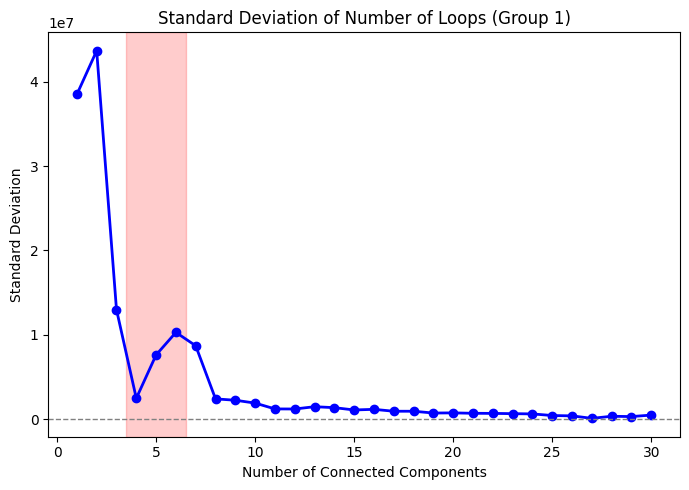

In [ ]:
plot_std_cycles(num_components_dc200, num_loops_dc200, 5, components_list, save=True, title='Standard Deviation of Number of Loops (Group 1)')

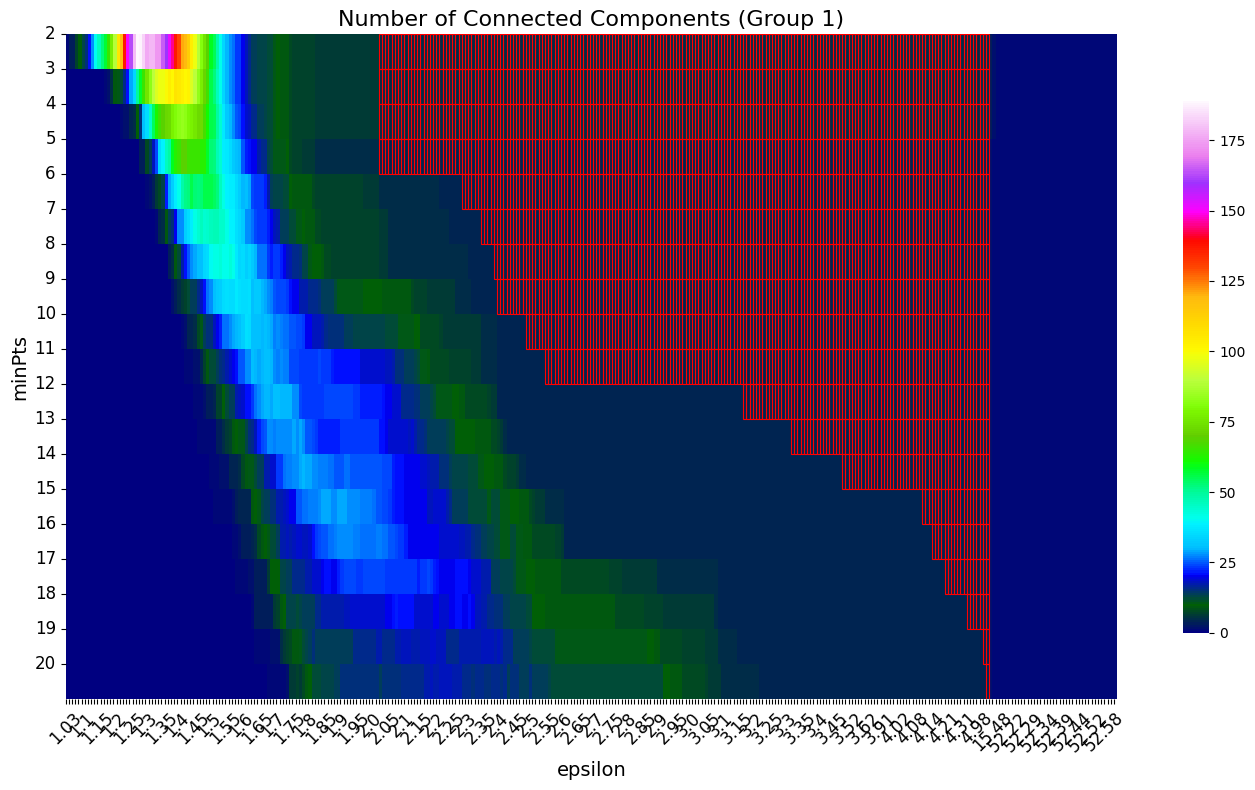

In [ ]:
file_name = '50_5_1000/50_5_1000_20_0.csv'
create_heatmap(
    input_file='/content/drive/MyDrive/Colab Notebooks/'+file_name,
    metric="num_connected_components",
    highlight=True,
    title ='Number of Connected Components (Group 1)',
    #minPts_limit=(2, 14),
    #eps_limit=(2, 5)
)

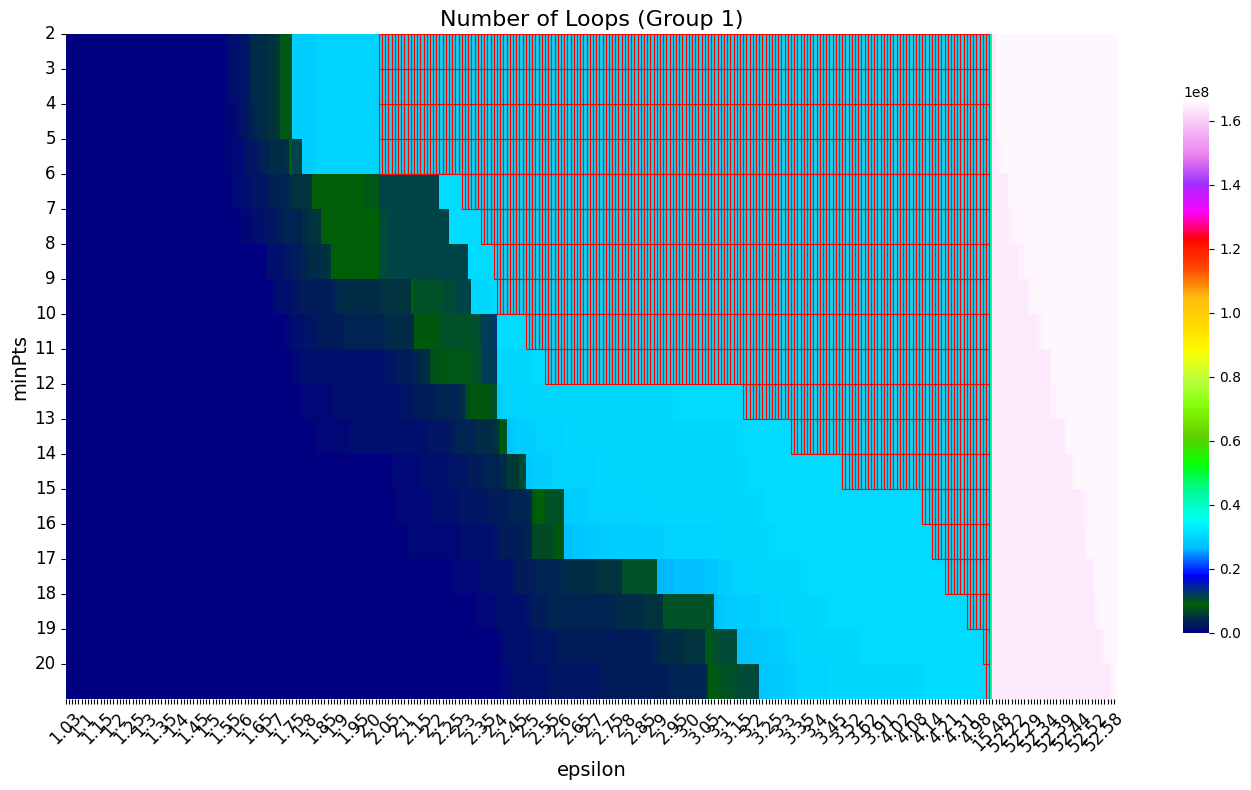

In [ ]:
create_heatmap(
    input_file='/content/drive/MyDrive/Colab Notebooks/'+file_name,
    metric="num_loops",
    highlight=True,
    title ='Number of Loops (Group 1)',
    #minPts_limit=(5, 20),
    #eps_limit=(2, 5)
)

7.990241561350184


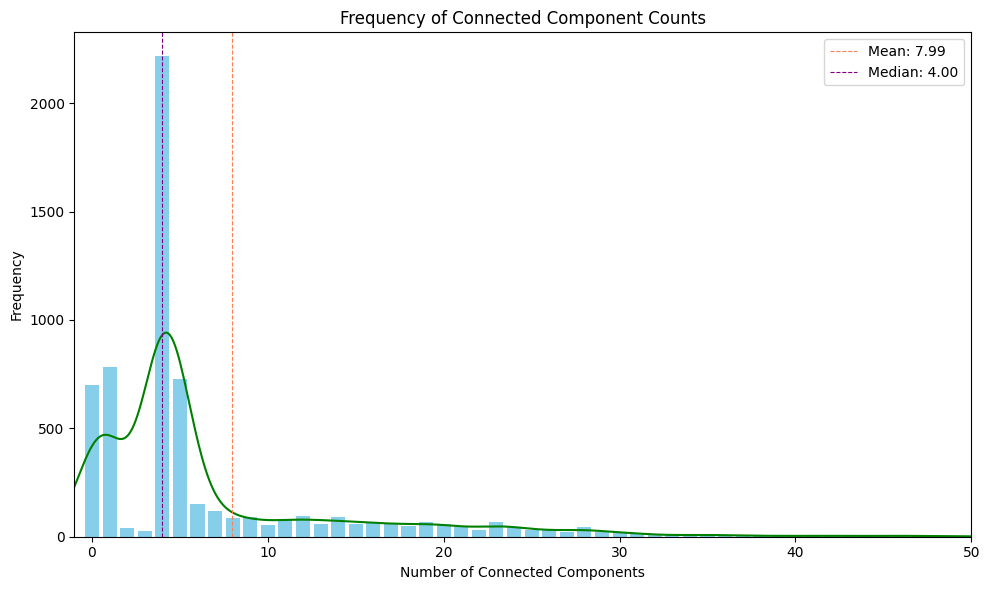

[(4, 2216), (1, 783), (5, 728), (0, 700), (6, 151), (7, 119), (12, 95), (9, 93), (14, 91), (8, 85), (11, 82), (23, 69), (16, 67), (19, 67), (17, 63), (13, 59), (20, 58), (15, 57), (10, 53), (18, 49), (28, 45), (21, 44), (24, 44), (2, 39), (25, 32), (22, 30), (26, 29), (3, 28), (27, 24), (29, 21), (30, 20), (31, 17), (35, 13), (34, 7), (32, 7), (46, 6), (52, 6), (65, 6), (41, 6), (56, 6), (33, 6), (38, 5), (42, 5), (36, 5), (69, 4), (45, 4), (44, 4), (37, 4), (39, 4), (98, 3), (82, 3), (66, 3), (73, 3), (63, 3), (53, 3), (47, 3), (40, 2), (77, 2), (89, 2), (137, 2), (178, 2), (173, 2), (104, 2), (75, 2), (59, 2), (55, 2), (48, 2), (58, 2), (90, 2), (95, 2), (101, 2), (54, 2), (78, 2), (49, 2), (43, 2), (57, 1), (106, 1), (118, 1), (150, 1), (163, 1), (179, 1), (189, 1), (188, 1), (183, 1), (176, 1), (165, 1), (160, 1), (152, 1), (145, 1), (130, 1), (121, 1), (119, 1), (113, 1), (81, 1), (50, 1), (100, 1), (107, 1), (105, 1), (103, 1), (102, 1), (83, 1), (71, 1), (62, 1), (72, 1), (80, 1

In [ ]:
top_dc200 = frequency_plot(np.array(num_components_dc200), lim_start=-1, lim_end=50, save=True, code='_5_1000_20_0')
print(top_dc200)

In [ ]:
#components_most_frequency_dc = [value for value, _ in top_dc200]
components_most_frequency_dc = list(range(1, 31))
print(components_most_frequency_dc)

num_connected_components = np.array(num_components_dc200)

graph_labels = np.array(graph_labels_dc200)



In [ ]:
nmi_ami_ari_dict = compute_nmi_per_component(components_most_frequency_dc, num_connected_components, graph_labels, "/content/drive/MyDrive/Colab Notebooks/NMI_5_1000_20_0.csv")
print(nmi_ami_ari_dict)

In [ ]:
nmi_ami_ari_dict = compute_nmi_per_component(components_most_frequency_dc, num_connected_components, graph_labels, code='group1')
print(nmi_ami_ari_dict)

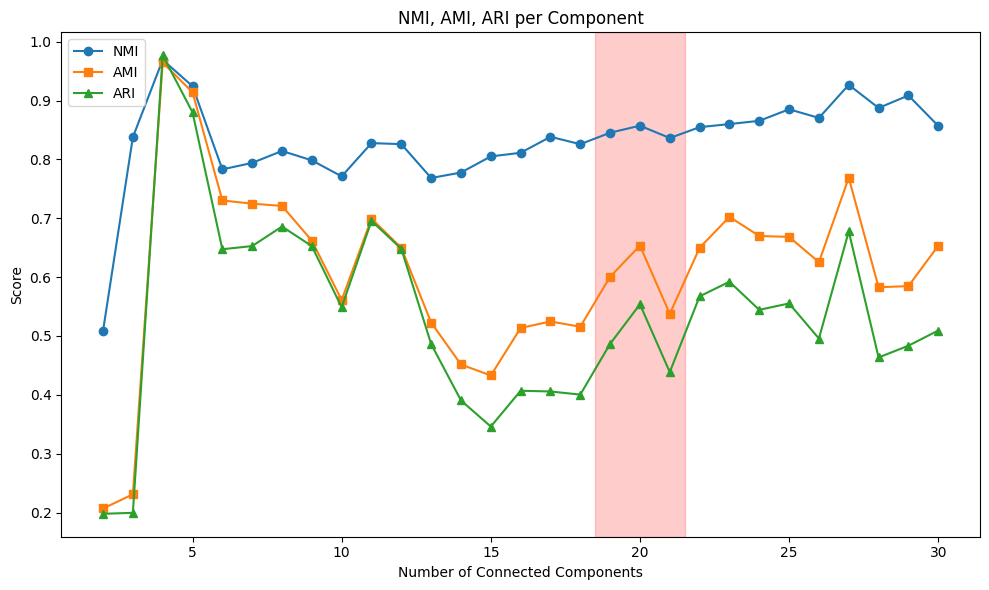

In [ ]:
plot_metrics(nmi_ami_ari_dict, 20, "group_1")

In [ ]:
plot_metric_sums()

In [ ]:
top_nmi = get_top_components_by_metric(nmi_ami_ari_dict, 'NMI', top_n=5)
top_ami = get_top_components_by_metric(nmi_ami_ari_dict, 'AMI', top_n=5)
top_ari = get_top_components_by_metric(nmi_ami_ari_dict, 'ARI', top_n=5)

Top 5 components by NMI:
Component: 4, NMI: 0.969
Component: 43, NMI: 0.961
Component: 40, NMI: 0.945
Component: 45, NMI: 0.932
Component: 36, NMI: 0.929
Top 5 components by AMI:
Component: 4, AMI: 0.965
Component: 5, AMI: 0.914
Component: 43, AMI: 0.811
Component: 27, AMI: 0.769
Component: 47, AMI: 0.756
Top 5 components by ARI:
Component: 4, ARI: 0.977
Component: 5, ARI: 0.880
Component: 11, ARI: 0.696
Component: 8, ARI: 0.686
Component: 43, ARI: 0.681


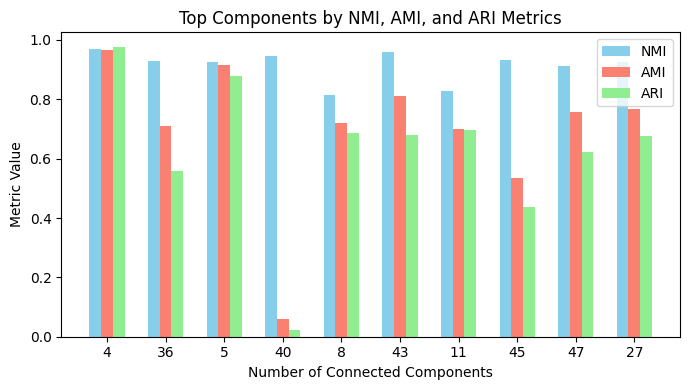

In [ ]:
# Extract the components and the corresponding metrics
top_components = list(set([comp for comp, _ in top_nmi + top_ami + top_ari]))

# Create arrays to hold the values for each metric
nmi_values = [nmi_ami_ari_dict[comp]['NMI'] for comp in top_components]
ami_values = [nmi_ami_ari_dict[comp]['AMI'] for comp in top_components]
ari_values = [nmi_ami_ari_dict[comp]['ARI'] for comp in top_components]

# Set up the bar chart
x = np.arange(len(top_components))  # X axis for components
width = 0.2  # The width of the bars

# Plot each metric with offsets for NMI, AMI, and ARI
fig, ax = plt.subplots(figsize=(7, 4))

bars1 = ax.bar(x - width, nmi_values, width, label='NMI', color='skyblue')
bars2 = ax.bar(x, ami_values, width, label='AMI', color='salmon')
bars3 = ax.bar(x + width, ari_values, width, label='ARI', color='lightgreen')

# Add labels, title, and custom ticks
ax.set_xlabel('Number of Connected Components')
ax.set_ylabel('Metric Value')
ax.set_title('Top Components by NMI, AMI, and ARI Metrics')
ax.set_xticks(x)
ax.set_xticklabels(top_components)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
code='_5_1000_20_0'
fig.savefig("Top_components_by_NMI_AMI_ARI_Metrics"+code+".png")

### 15_2000

In [ ]:
file_name = '50_15_2000/50_15_2000_20_0.csv'
minPts200_10, eps_values200_10, num_components_dc200_10, num_loops_dc200_10, nmi_values_dc200_10, ami_values_dc200_10, ari_values_dc200_10, num_loops_norm_by_edges_dc200_10, num_loops_norm_by_edges_comp_dc200_10, graph_labels_dc200_10 = read_dcdist_results('/content/drive/MyDrive/Colab Notebooks/'+file_name)

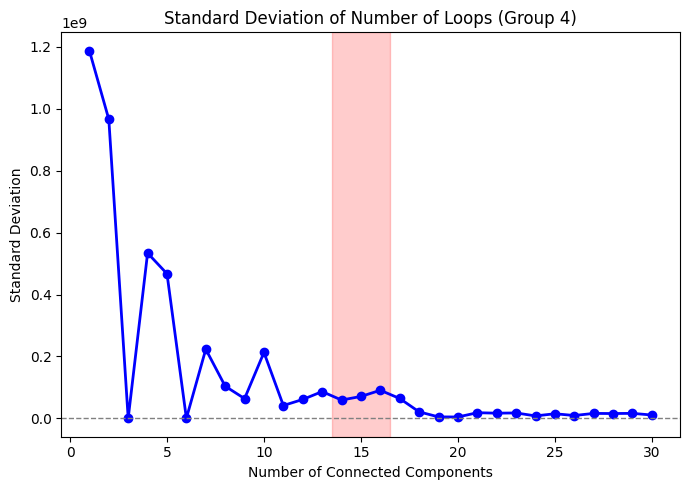

In [ ]:
plot_std_cycles(num_components_dc505, num_loops_dc505, 15,  components_list, save=True, title='Standard Deviation of Number of Loops (Group 4)')

In [ ]:
components_list = list(range(1, 31))

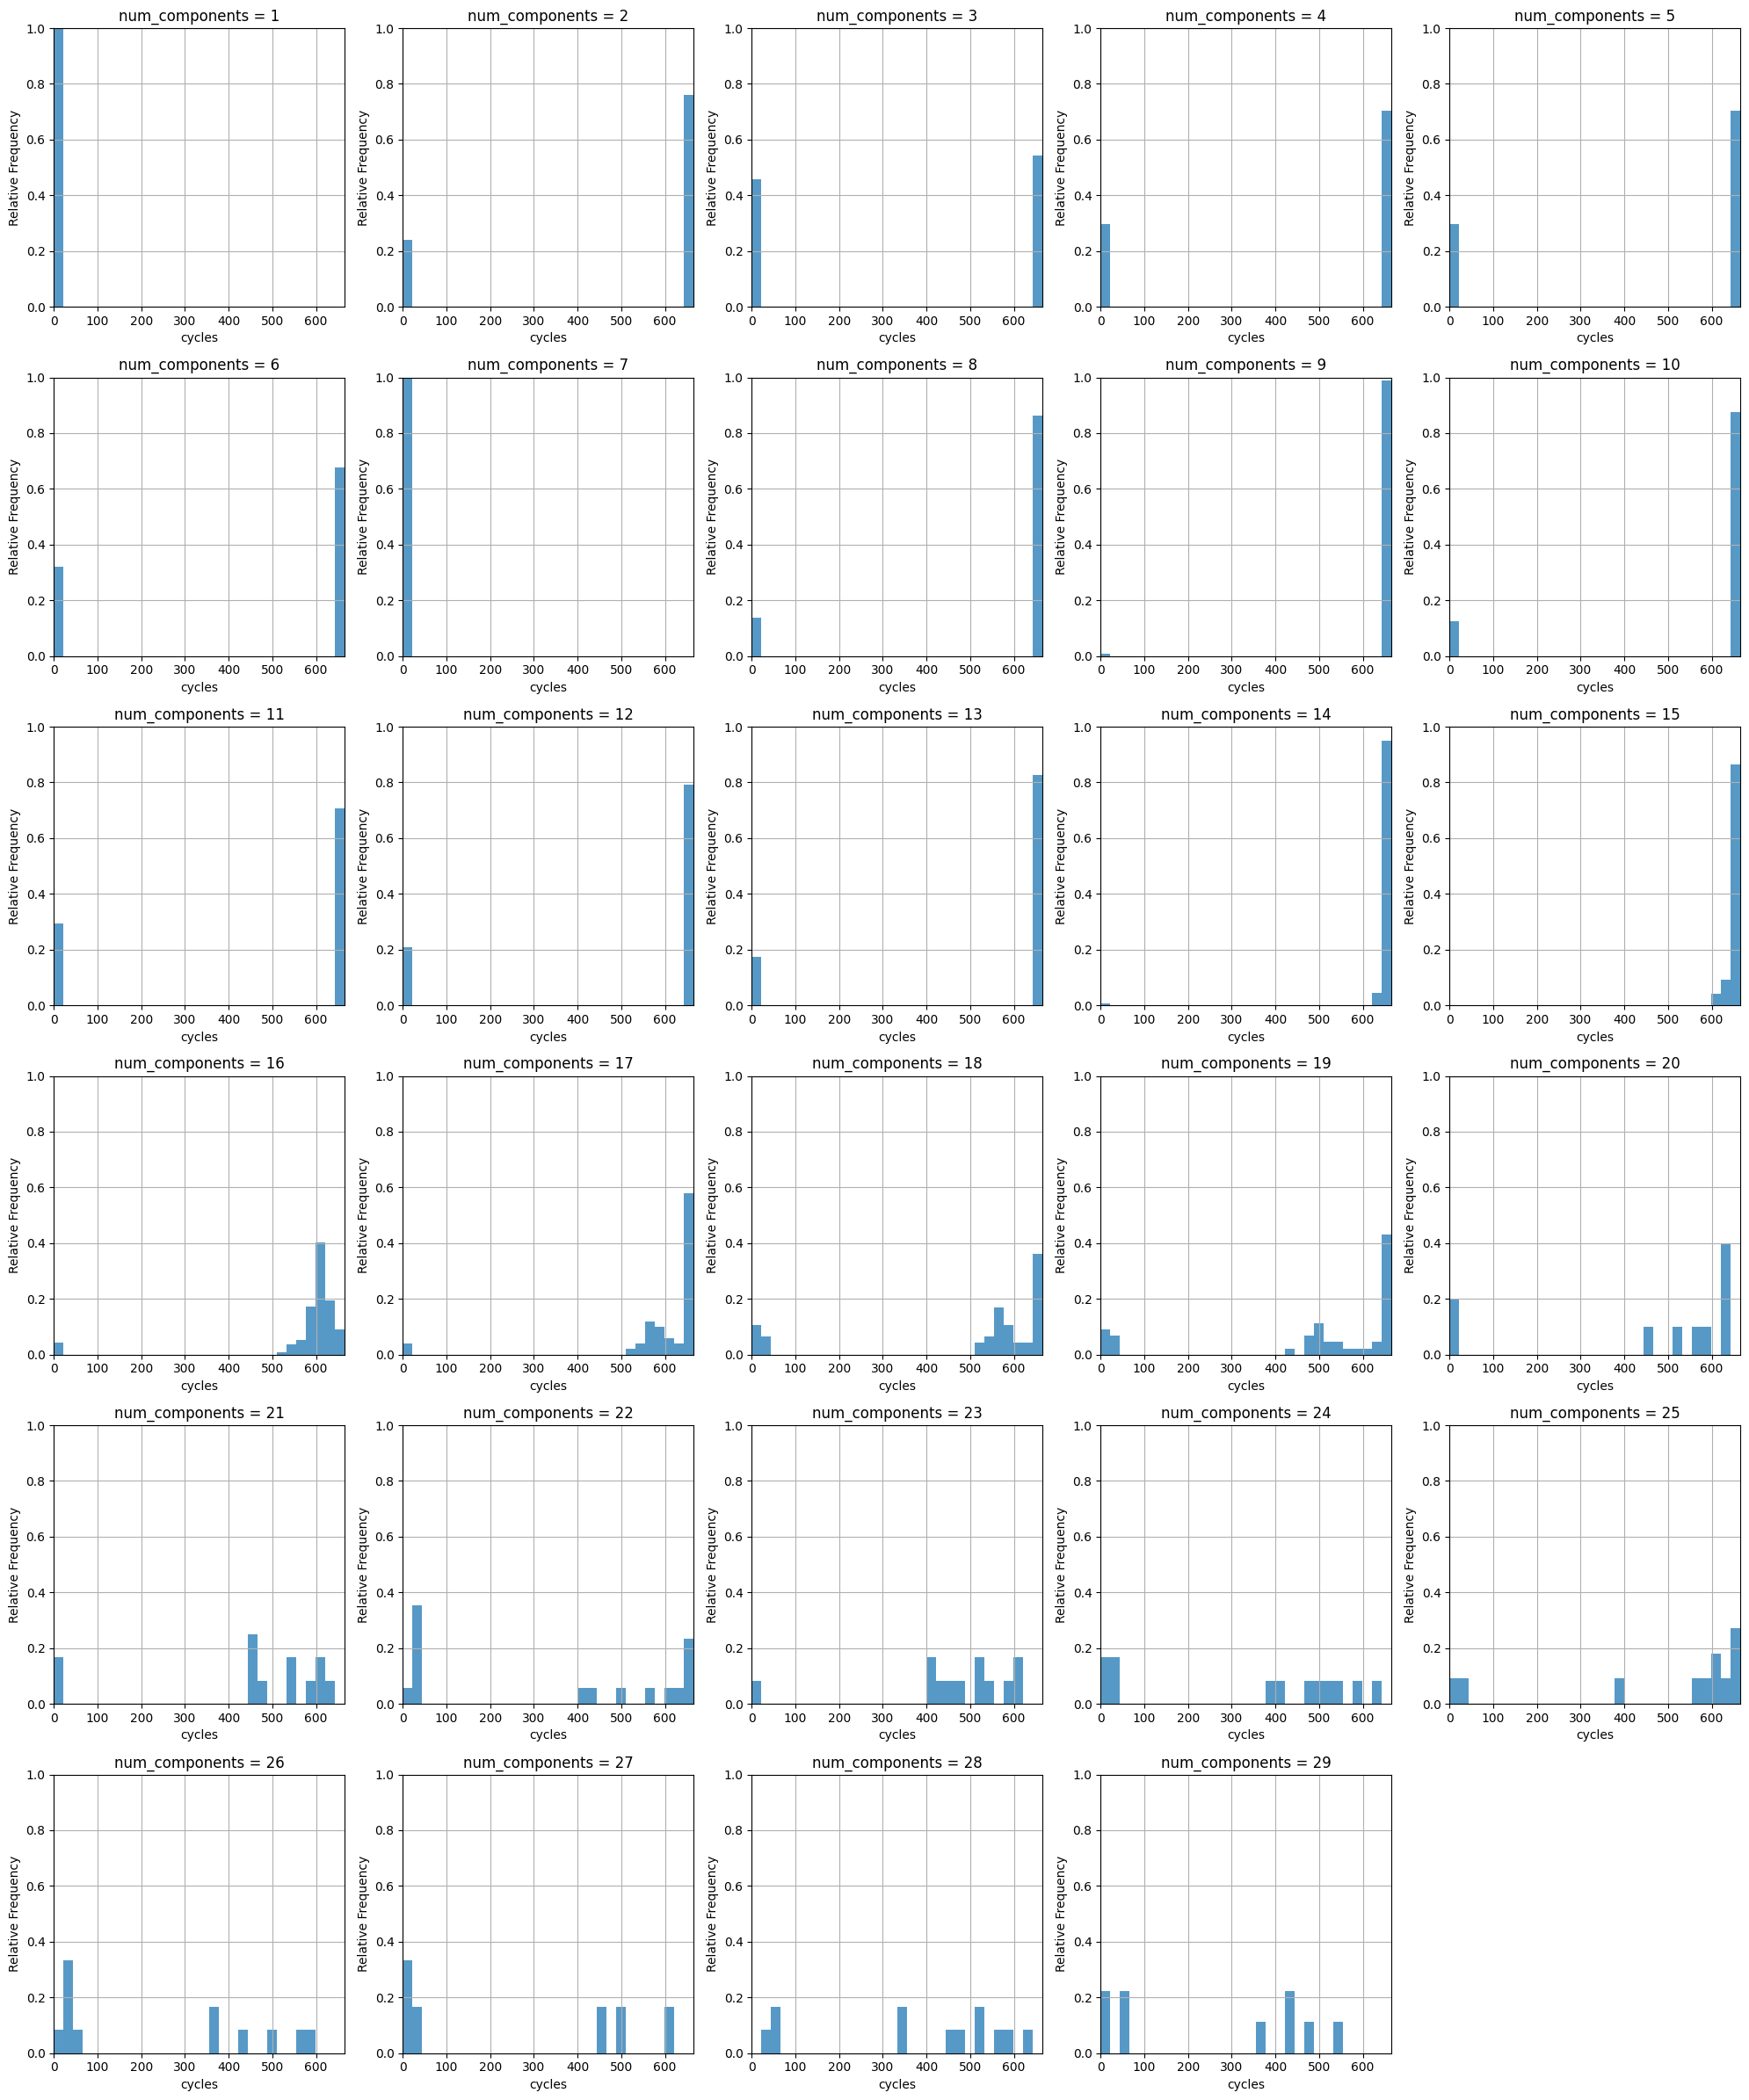

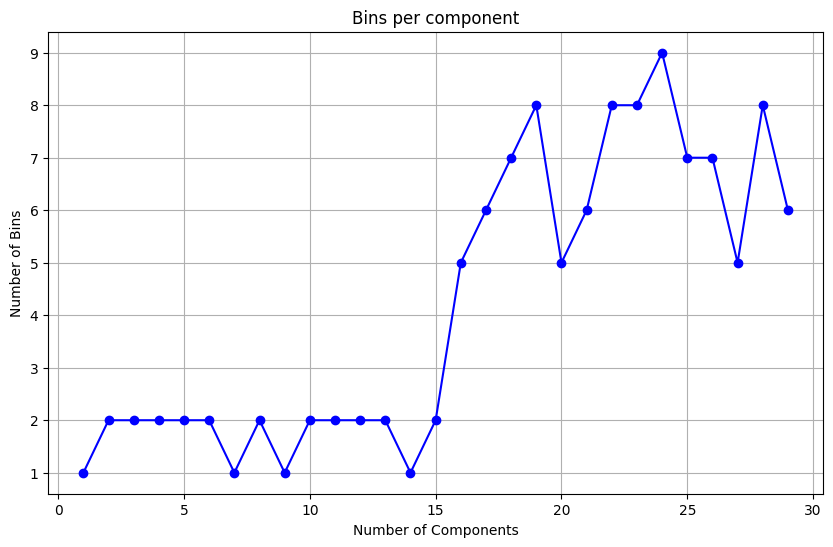

In [ ]:
plot_cycles_relative_frequency_for_component(num_components_dc200_10, num_loops_norm_by_edges_dc200_10, components_list, min_cycles=0, max_cycles=0, save=True, title='15_2000')

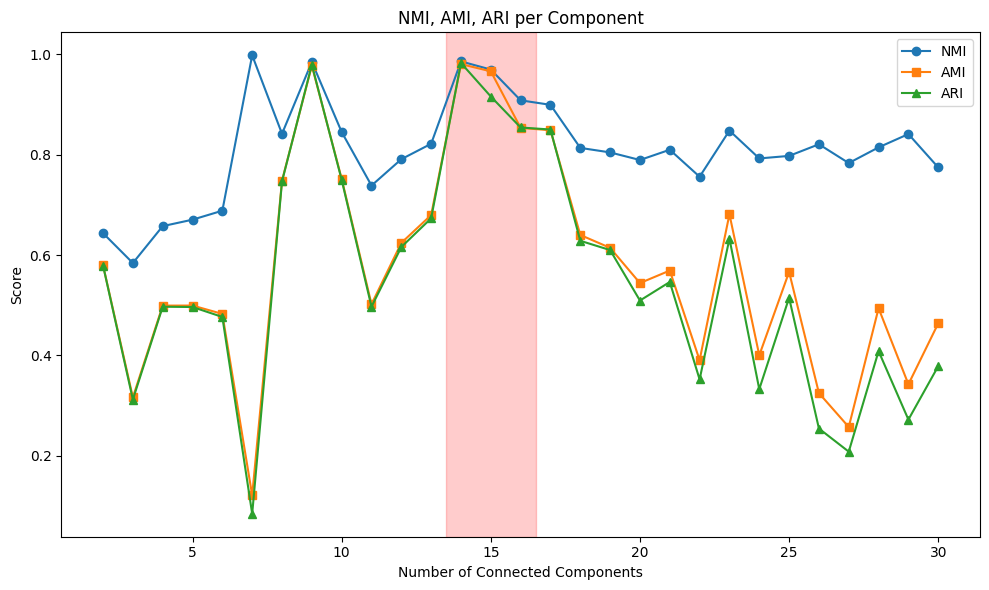

In [ ]:
plot_metrics(nmi_ami_ari_dict, 15, "group_3")

### 10_1500

In [ ]:
file_name = 'dc_dist_parameters_50_10_1500_withoutnoise.csv'
minPts505, eps_values505, num_components_dc505, num_loops_dc505, nmi_values_dc505, ami_values_dc505, ari_values_dc505, num_loops_norm_by_edges_dc505, num_loops_norm_by_edges_comp_dc505, graph_labels_dc505 = read_dcdist_results('/content/drive/MyDrive/Colab Notebooks/'+file_name)

In [ ]:
components_list = list(range(1, 31))

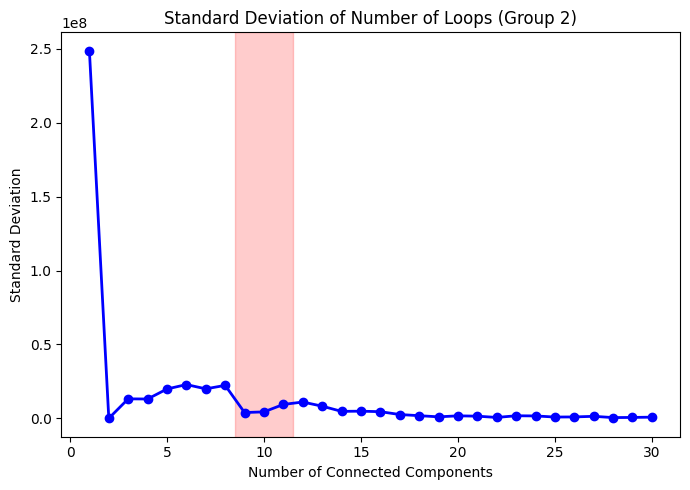

In [ ]:
plot_std_cycles(num_components_dc505, num_loops_dc505, 10, components_list, save=True, title='Standard Deviation of Number of Loops (Group 2)')

11.240344206523915


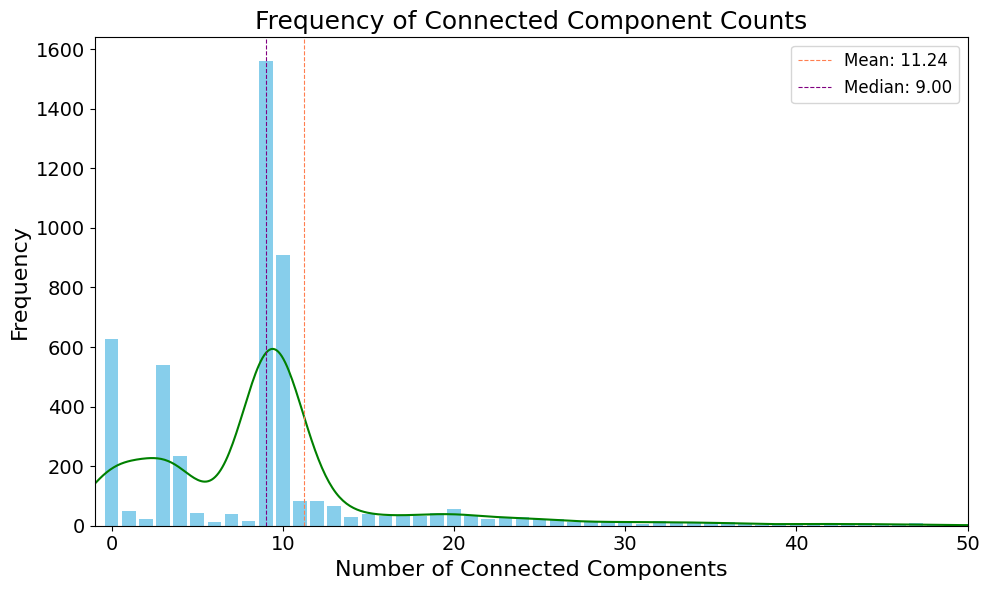

[(np.int64(9), 1562), (np.int64(10), 908), (np.int64(0), 627), (np.int64(3), 539), (np.int64(4), 234), (np.int64(11), 82), (np.int64(12), 82), (np.int64(13), 66), (np.int64(20), 55), (np.int64(1), 50), (np.int64(5), 43), (np.int64(19), 43), (np.int64(15), 38), (np.int64(7), 38), (np.int64(21), 33), (np.int64(16), 32), (np.int64(17), 32), (np.int64(18), 31), (np.int64(24), 30), (np.int64(14), 30), (np.int64(23), 27), (np.int64(2), 24), (np.int64(22), 22), (np.int64(25), 22), (np.int64(26), 21), (np.int64(8), 17), (np.int64(30), 16), (np.int64(32), 16), (np.int64(6), 13), (np.int64(36), 12), (np.int64(29), 12), (np.int64(28), 12), (np.int64(27), 11), (np.int64(34), 11), (np.int64(33), 10), (np.int64(44), 9), (np.int64(35), 9), (np.int64(47), 8), (np.int64(40), 8), (np.int64(41), 7), (np.int64(37), 7), (np.int64(31), 7), (np.int64(42), 5), (np.int64(64), 5), (np.int64(93), 4), (np.int64(140), 4), (np.int64(53), 4), (np.int64(43), 4), (np.int64(54), 4), (np.int64(52), 3), (np.int64(74), 3)

In [ ]:
top_dc505 = frequency_plot(np.array(num_components_dc505), lim_start=-1, lim_end=50, save=True, code='_10_1500_20_0')
print(top_dc505)

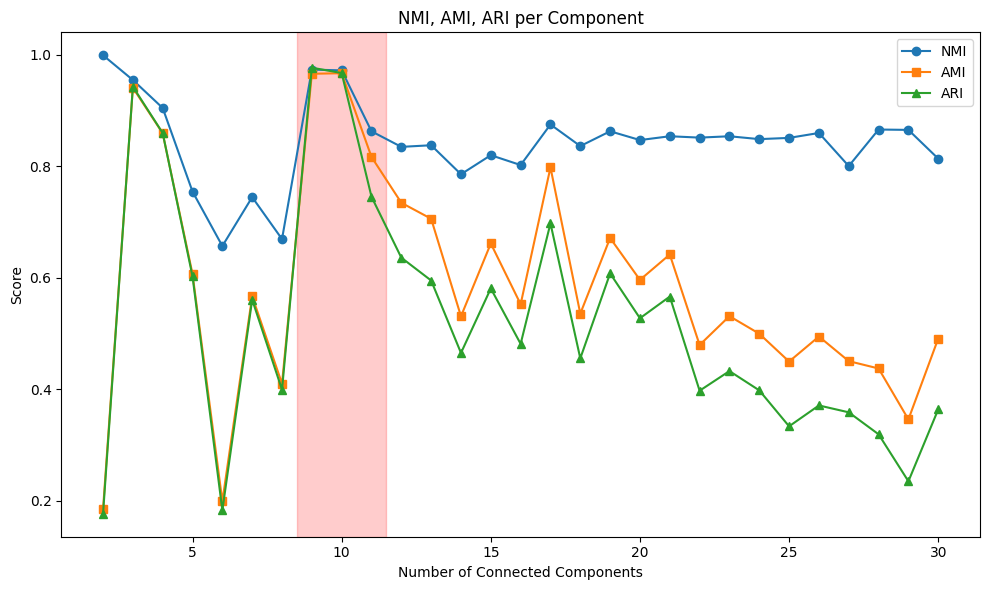

In [ ]:
plot_metrics(nmi_ami_ari_dict, 10, "group_2")

### 12_2000 (Group3)

In [ ]:
file_name = 'dc_dist_parameters_50_12_2000_0_1.csv'
minPts505, eps_values505, num_components_dc505, num_loops_dc505, nmi_values_dc505, ami_values_dc505, ari_values_dc505, num_loops_norm_by_edges_dc505, num_loops_norm_by_edges_comp_dc505, graph_labels_dc505 = read_dcdist_results('/content/drive/MyDrive/Colab Notebooks/'+file_name)

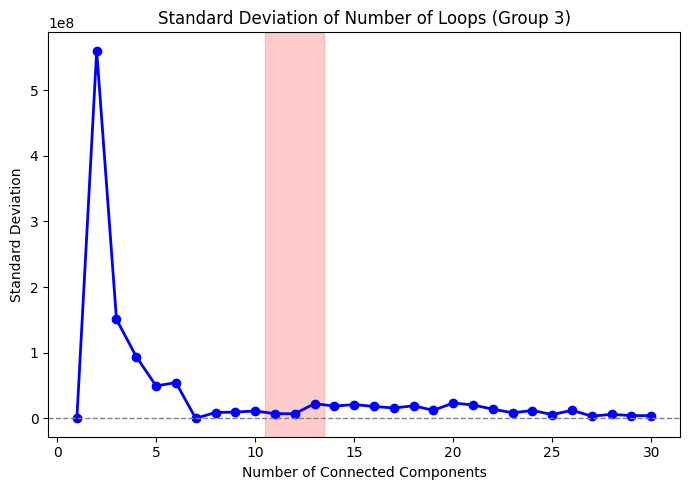

In [ ]:
plot_std_cycles(num_components_dc505, num_loops_dc505, 12,  components_list, save=True, title='Standard Deviation of Number of Loops (Group 3)')

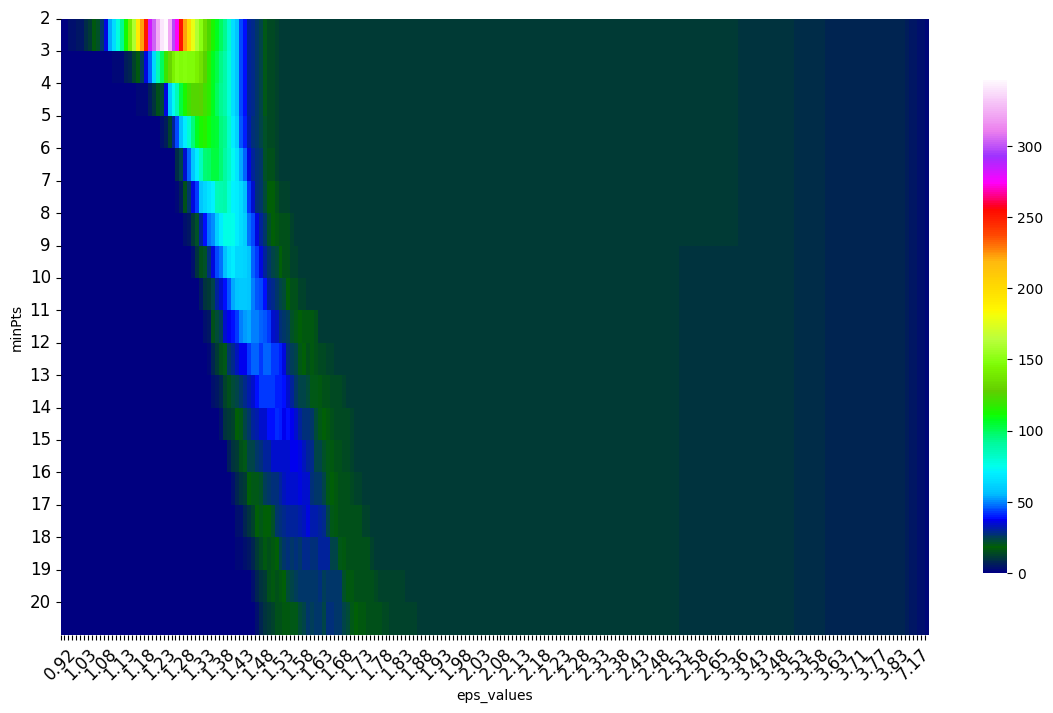

In [ ]:
create_heatmap(
    input_file='/content/drive/MyDrive/Colab Notebooks/'+file_name,
    metric="num_connected_components",
    highlight=True,
    title ='Number of Connected Components (Group 3)',
    #minPts_limit=(5, 20),
    #eps_limit=(1.52, 2.56)
)

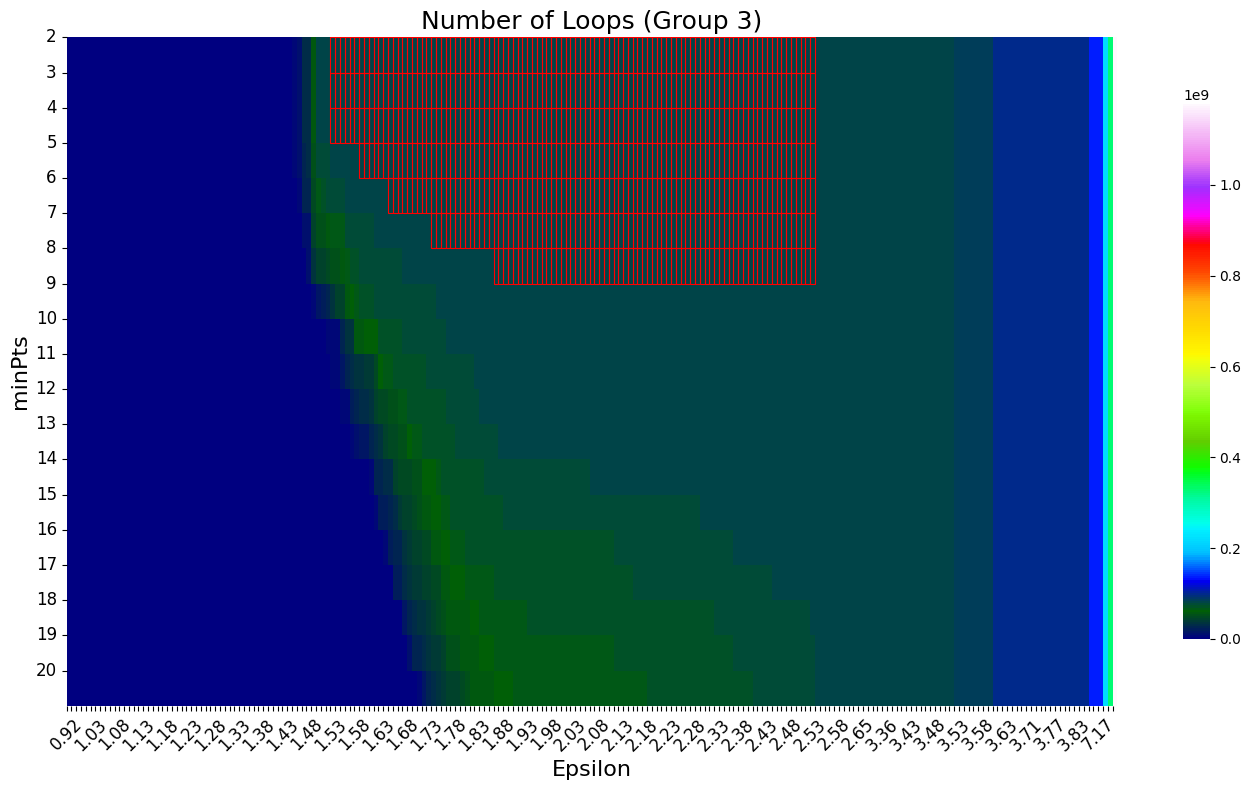

In [ ]:
create_heatmap(
    input_file='/content/drive/MyDrive/Colab Notebooks/'+file_name,
    metric="num_loops",
    highlight=True,
    title ='Number of Loops (Group 3)',
    #minPts_limit=(5, 20),
    #eps_limit=(1.52, 2.56)
)

13.485940879596251


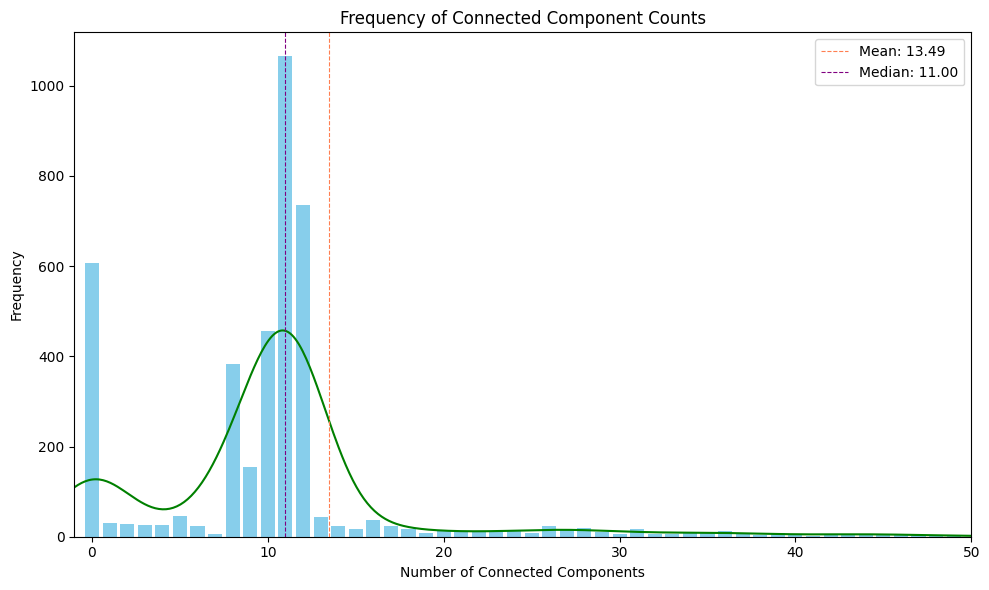

[(np.int64(11), 1065), (np.int64(12), 736), (np.int64(0), 607), (np.int64(10), 455), (np.int64(8), 383), (np.int64(9), 154), (np.int64(5), 45), (np.int64(13), 43), (np.int64(16), 37), (np.int64(1), 30), (np.int64(2), 29), (np.int64(3), 27), (np.int64(4), 25), (np.int64(14), 24), (np.int64(6), 24), (np.int64(17), 23), (np.int64(26), 23), (np.int64(28), 20), (np.int64(31), 18), (np.int64(15), 17), (np.int64(18), 17), (np.int64(27), 16), (np.int64(24), 16), (np.int64(36), 12), (np.int64(20), 12), (np.int64(21), 11), (np.int64(29), 11), (np.int64(22), 11), (np.int64(34), 11), (np.int64(23), 10), (np.int64(35), 9), (np.int64(19), 9), (np.int64(39), 8), (np.int64(25), 8), (np.int64(44), 7), (np.int64(37), 7), (np.int64(43), 7), (np.int64(32), 6), (np.int64(46), 6), (np.int64(30), 6), (np.int64(42), 6), (np.int64(57), 5), (np.int64(40), 5), (np.int64(33), 5), (np.int64(7), 5), (np.int64(63), 4), (np.int64(70), 4), (np.int64(45), 4), (np.int64(38), 4), (np.int64(49), 4), (np.int64(64), 3), (np

In [ ]:
top_dc505 = frequency_plot(np.array(num_components_dc505), lim_start=-1, lim_end=50, save=True, code="_12_2000_0_1")
print(top_dc505)